### Mutual Information

La información mutua se parece mucho a la correlación en el sentido de que mide la relación entre dos cantidades. La ventaja de la información mutua es que puede detectar cualquier *tipo* de relación, mientras que la correlación solo detecta relaciones *lineales*.

La información mutua es una excelente métrica de propósito general y especialmente útil al comienzo del desarrollo de funciones cuando es posible que aún no sepa qué modelo le gustaría usar. Está:

* Fácil de usar e interpretar.
* Computacionalmente eficiente.
* teóricamente bien fundamentado.
* Resistente al sobreajuste.
* Rcapaz de detectar cualquier tipo de relación.


#### Información mutua y lo que mide
La información mutua describe las relaciones en términos de *incertidumbre*. La **información mutua** (MI) entre dos cantidades es una medida del grado en que el conocimiento de una cantidad reduce la incertidumbre sobre la otra. Si supiera el valor de una función, ¿cuánto más seguro estaría sobre el objetivo?

**Nota técnica:** Lo que llamamos incertidumbre se mide utilizando una cantidad de la teoría de la información conocida como "entropía". La entropía de una variable significa aproximadamente: Por el contrario, en teoría, no existe un límite superior para lo que puede ser MI. En la práctica, los valores superiores a 2,0 son poco comunes. (La información mutua es una cantidad logarítmica, por lo que aumenta muy lentamente).

#### Interpretación de las puntuaciones de información mutua
La menor información mutua posible entre cantidades es 0.0. Cuando MI es cero, las cantidades son independientes: ninguna puede decirle nada sobre la otra. Por el contrario, en teoría, no existe un límite superior para lo que puede ser MI. En la práctica, los valores superiores a 2,0 son poco comunes. (La información mutua es una cantidad logarítmica, por lo que aumenta muy lentamente).

La siguiente figura le dará una idea de cómo los valores de MI corresponden al tipo y grado de asociación que tiene una característica con el objetivo.

<div align="center"><img src='../images/IM.png' alt="drawing" width="700"  /> 

 **Izquierda:** la información mutua aumenta a medida que la dependencia entre la función y el objetivo se vuelve más estricta. **Derecha:** la información mutua puede capturar cualquier tipo de asociación (no solo lineal, como la correlación).
 </div>


A continuación, se incluyen algunas cosas para recordar al aplicar información mutua: 
* MI puede ayudarlo a comprender el potencial relativo de una característica como predictor del objetivo, considerado por sí mismo.
* Es posible que una función sea muy informativa cuando interactúa con otras funciones, pero no tan informativa por sí sola. MI no puede detectar interacciones entre funciones. Es una métrica univariante.
* La utilidad real de una función depende del modelo con el que la use. Una característica solo es útil en la medida en que su relación con el objetivo sea una que su modelo pueda aprender. El hecho de que una función tenga una puntuación alta de MI no significa que su modelo pueda hacer algo con esa información. Es posible que primero deba transformar la función para exponer la asociación.




In [126]:
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [107]:
PATH = '../in/train.csv'

df = pd.read_csv(PATH)

### Drop  bad columns with Mising values

In [108]:
rate_mising_cols = (df.isna().sum() * 100 / len(df)).sort_values(ascending=False)

In [109]:
rate_mising_cols[:20]

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageCond       5.547945
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
Id               0.000000
dtype: float64

In [111]:
bad_features = rate_mising_cols[rate_mising_cols > 30].index.values

In [112]:
df.drop(bad_features, axis=1, inplace=True)

In [113]:
df.shape

(1460, 76)

### Imputer mising values

In [114]:
df_object = df.select_dtypes('object')
df_num  = df.select_dtypes('number')

In [115]:
numerical_imputer = SimpleImputer(strategy='constant')
object_imputer = SimpleImputer(strategy='most_frequent')
ordinal = OrdinalEncoder(handle_unknown='error')

In [116]:
df_num_imp = pd.DataFrame(numerical_imputer.fit_transform(df_num), columns= df_num.columns)
df_object_imp = pd.DataFrame(object_imputer.fit_transform(df_object), columns= df_object.columns)
df_object_ord = pd.DataFrame(ordinal.fit_transform(df_object_imp), columns=df_object_imp.columns)

In [117]:
df_ = pd.concat([df_num_imp,df_object_ord], axis=1)

### Mutual information

In [119]:
X = df_.drop(['SalePrice'], axis=1)
y = df.pop('SalePrice')

In [121]:
discrete_features = df.dtypes == int

In [122]:
mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)

In [123]:
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

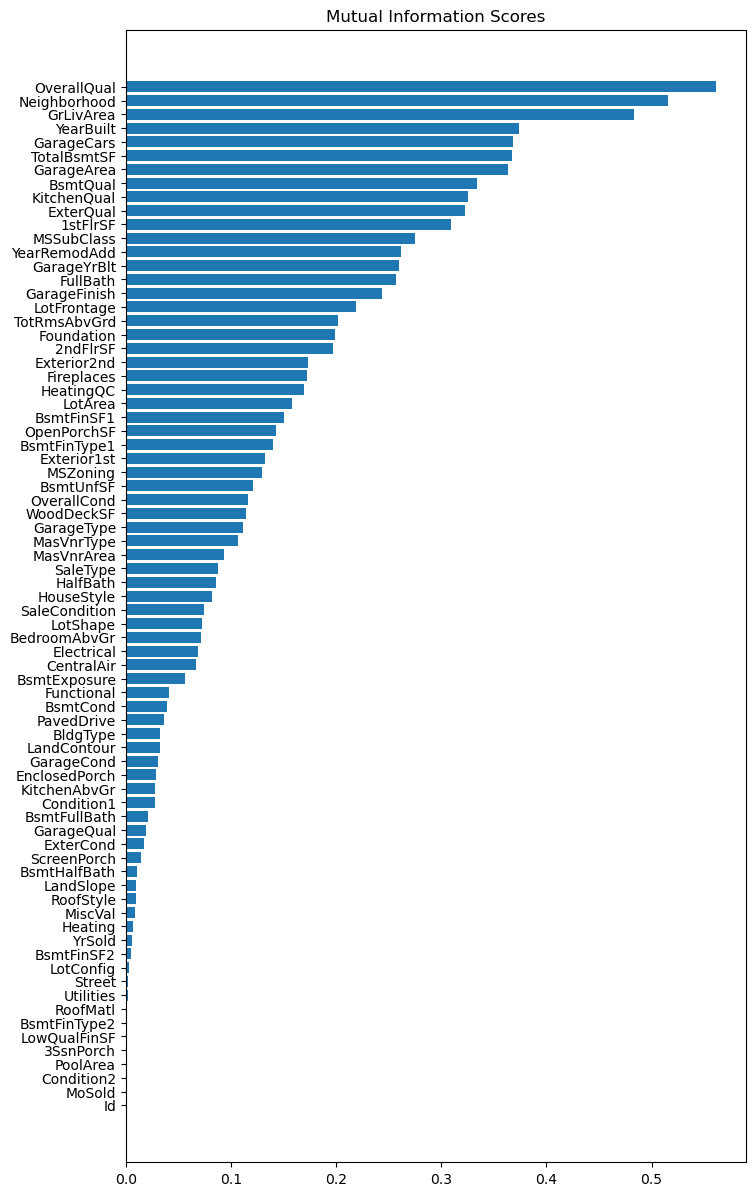

In [124]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks, fontsize=10)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 15))
plot_mi_scores(mi_scores)

In [128]:
better_features = mi_scores[mi_scores > 0.04].index
X_ = X[better_features]

### Model

In [131]:
model = RandomForestRegressor(n_estimators = 10, criterion='mae', max_depth=15)
model.fit(X_, y)

RandomForestRegressor(criterion='mae', max_depth=15, n_estimators=10)

In [135]:
X_.columns

Index(['OverallQual', 'Neighborhood', 'GrLivArea', 'YearBuilt', 'GarageCars',
       'TotalBsmtSF', 'GarageArea', 'BsmtQual', 'KitchenQual', 'ExterQual',
       '1stFlrSF', 'MSSubClass', 'YearRemodAdd', 'GarageYrBlt', 'FullBath',
       'GarageFinish', 'LotFrontage', 'TotRmsAbvGrd', 'Foundation', '2ndFlrSF',
       'Exterior2nd', 'Fireplaces', 'HeatingQC', 'LotArea', 'BsmtFinSF1',
       'OpenPorchSF', 'BsmtFinType1', 'Exterior1st', 'MSZoning', 'BsmtUnfSF',
       'OverallCond', 'WoodDeckSF', 'GarageType', 'MasVnrType', 'MasVnrArea',
       'SaleType', 'HalfBath', 'HouseStyle', 'SaleCondition', 'LotShape',
       'BedroomAbvGr', 'Electrical', 'CentralAir', 'BsmtExposure',
       'Functional'],
      dtype='object')

### Result

In [132]:
pred_example = pd.read_csv('../in/sample_submission.csv')

In [138]:
test = pd.read_csv('../in/test.csv')
test = test[X_.columns]

test_num = test.select_dtypes('number')
test_obj = test.select_dtypes('object')

In [139]:
test_num_imp = pd.DataFrame(numerical_imputer.fit_transform(test_num), columns= test_num.columns)
test_obj_imp = pd.DataFrame(object_imputer.fit_transform(test_obj), columns= test_obj.columns)
df_object_ord = pd.DataFrame(ordinal.fit_transform(test_obj_imp), columns=test_obj_imp.columns)

In [141]:
test_ = pd.concat([test_num_imp,df_object_ord], axis=1)

In [142]:
pred = model.predict(test_)

In [144]:
predict = pd.DataFrame(pred, columns=['SalePrice'])
predict['Id'] = index=pred_example.Id
predict = predict.set_index('Id')
predict.to_csv('../out/model_MI.csv')
predict.head()

,SalePrice
Id,
1461,131530.0
1462,158350.0
1463,124490.0
1464,144750.0
1465,290475.0
